In [1]:
import h5py
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix
from collections import Counter

In [2]:
class ConnectomeDataset(Dataset):
    def __init__(self, h5_file, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # 📌 Définition des 3 matrices utilisées comme canaux
        keys = ['FC_correlation', 'SC_gFA', 'SC_density']

        with h5py.File(h5_file, 'r') as f:
            # 📌 On charge les matrices pour CHAQUE patient, en empilant les 3 matrices en (68,68,3)
            num_patients = f[keys[0]]['ctrl'].shape[0]  # 27 patients dans chaque groupe

            for i in range(num_patients):  # Parcourir les patients
                # 📌 Récupérer les matrices SC/FC pour un patient (CTRL)
                ctrl_matrices = np.stack([f[key]['ctrl'][i] for key in keys], axis=-1)  # (68, 68, 3)
                schz_matrices = np.stack([f[key]['schz'][i] for key in keys], axis=-1)  # (68, 68, 3)

                # 📌 Ajouter dans les listes
                self.data.append(ctrl_matrices)
                self.labels.append(0)  # 0 = CTRL
                
                self.data.append(schz_matrices)
                self.labels.append(1)  # 1 = SCHZ

        # 📌 Convertir en numpy array pour éviter les erreurs de format
        self.data = np.array(self.data, dtype=np.float32)  # Convertir en float32 proprement
        self.labels = np.array(self.labels, dtype=np.int64)  # Format compatible avec PyTorch

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # (68, 68, 3)
        label = self.labels[idx]

        # 📌 Normalisation individuelle pour chaque canal
        for i in range(3):  
            img[:, :, i] = (img[:, :, i] - img[:, :, i].min()) / (img[:, :, i].max() - img[:, :, i].min() + 1e-8)

        # 📌 Convertir en `uint8` (0-255)
        img = np.uint8(img * 255)

        # 📌 Convertir en image PIL (format RGB)
        img = Image.fromarray(img, mode="RGB")

        # 📌 Appliquer les transformations
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [11]:
# ----------------------------
# 2️⃣ Préparation des données et DataLoader
# ----------------------------

from sklearn.model_selection import train_test_split

# 📌 Transformation des images (adapté à DenseNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adapter à DenseNet
    transforms.ToTensor(),  # Convertir en Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 📌 Chargement du dataset
h5_path = "Data_ML/SC_FC_dataset_filtered_68x68.h5"
dataset = ConnectomeDataset(h5_path, transform=transform)

# 📌 Séparer les indices des patients CTRL et SCHZ
ctrl_indices = [i for i, label in enumerate(dataset.labels) if label == 0]  # CTRL
schz_indices = [i for i, label in enumerate(dataset.labels) if label == 1]  # SCHZ

# 📌 Utiliser directement les labels pour stratifier, pas les indices.
ctrl_train, ctrl_val = train_test_split(
    ctrl_indices, test_size=0.3, random_state=42, stratify=[dataset.labels[i] for i in ctrl_indices]
)

schz_train, schz_val = train_test_split(
    schz_indices, test_size=0.3, random_state=42, stratify=[dataset.labels[i] for i in schz_indices]
)

# 📌 Fusion des indices pour former les datasets finaux
train_indices = ctrl_train + schz_train  # 70% du dataset
val_indices = ctrl_val + schz_val        # 30% du dataset

# 📌 Création des datasets équilibrés
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# 📌 Vérification de la répartition des classes
train_labels = [dataset.labels[i] for i in train_indices]
val_labels = [dataset.labels[i] for i in val_indices]

print("Répartition des classes dans Train :", Counter(train_labels))
print("Répartition des classes dans Validation :", Counter(val_labels))

# 📌 Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


Répartition des classes dans Train : Counter({np.int64(0): 18, np.int64(1): 18})
Répartition des classes dans Validation : Counter({np.int64(0): 9, np.int64(1): 9})


In [12]:
# ----------------------------
# 3️⃣ Définition du modèle ResNet18
# ----------------------------

# 📌 Charger ResNet18 pré-entraîné avec les poids ImageNet
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# 📌 Modifier la première couche pour accepter 3 canaux (FC_correlation, SC_ADC, SC_density)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=0, bias=False)

# 📌 Débloquer `conv1` pour qu'elle puisse s'entraîner
for param in model.conv1.parameters():
    param.requires_grad = True

# 📌 Modifier la dernière couche pour la classification binaire
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 64),  # Réduction à 64 neurones
    nn.ReLU(),
    nn.BatchNorm1d(64),  # Normalisation pour stabiliser l'entraînement
    nn.Dropout(0.5),  # Réduction du sur-apprentissage
    nn.Linear(64, 2)  # Classification binaire (CTRL vs SCHZ)
)

# 📌 Débloquer `fc` pour qu'il puisse s'entraîner
for param in model.fc.parameters():
    param.requires_grad = True

# 📌 Geler toutes les autres couches pour ne pas réentraîner tout le modèle
for name, param in model.named_parameters():
    if not (name.startswith("conv1") or name.startswith("fc")):
        param.requires_grad = False  # On met à jour uniquement `conv1` et `fc`

# 📌 Déplacer le modèle sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 📌 Vérification : Afficher les couches entraînables
print("🔹 Couches entraînées :")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"✅ {name}")

print("✅ ResNet18 chargé et adapté aux connectomes.")


🔹 Couches entraînées :
✅ conv1.weight
✅ fc.0.weight
✅ fc.0.bias
✅ fc.2.weight
✅ fc.2.bias
✅ fc.4.weight
✅ fc.4.bias
✅ ResNet18 chargé et adapté aux connectomes.


In [13]:
# 📌 Détection automatique du device (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()  # Activer Mixed Precision seulement si GPU dispo

# 📌 Définition du modèle et des hyperparamètres
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.0001, weight_decay=5e-4)

# 📌 Activer GradScaler uniquement si CUDA est disponible
scaler = GradScaler(enabled=use_amp)

num_epochs = 100
patience = 20
best_loss = float('inf')  
early_stop_counter = 0

best_model_path = "Model/best_resnet18_model_test.pth"

for epoch in range(num_epochs):
    # ----- ENTRAÎNEMENT -----
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        if len(inputs) == 0:
            continue

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda" if use_amp else "cpu", enabled=use_amp): 
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # ----- VALIDATION (ajoutée ici) -----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # 📌 Affichage des losses
    print(f"📌 Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # 📌 Early Stopping basé sur la Validation Loss
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Meilleur modèle sauvegardé avec Val Loss: {best_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"⏳ Pas d'amélioration... ({early_stop_counter}/{patience})")

    if early_stop_counter >= patience:
        print(f"🛑 Early Stopping activé après {epoch+1} epochs. Meilleure Val Loss: {best_loss:.4f}")
        break

# 📌 Charger le meilleur modèle après l'entraînement
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print("✅ Entraînement terminé, modèle optimal chargé !")


📌 Epoch 1/100 - Train Loss: 0.6837 - Val Loss: 0.7134
✅ Meilleur modèle sauvegardé avec Val Loss: 0.7134
📌 Epoch 2/100 - Train Loss: 0.6961 - Val Loss: 0.6958
✅ Meilleur modèle sauvegardé avec Val Loss: 0.6958
📌 Epoch 3/100 - Train Loss: 0.7906 - Val Loss: 0.6847
✅ Meilleur modèle sauvegardé avec Val Loss: 0.6847
📌 Epoch 4/100 - Train Loss: 0.7603 - Val Loss: 0.6415
✅ Meilleur modèle sauvegardé avec Val Loss: 0.6415
📌 Epoch 5/100 - Train Loss: 0.6937 - Val Loss: 0.6490
⏳ Pas d'amélioration... (1/20)
📌 Epoch 6/100 - Train Loss: 0.5813 - Val Loss: 0.6835
⏳ Pas d'amélioration... (2/20)
📌 Epoch 7/100 - Train Loss: 0.6314 - Val Loss: 0.7064
⏳ Pas d'amélioration... (3/20)
📌 Epoch 8/100 - Train Loss: 0.5730 - Val Loss: 0.6521
⏳ Pas d'amélioration... (4/20)
📌 Epoch 9/100 - Train Loss: 0.5463 - Val Loss: 0.6901
⏳ Pas d'amélioration... (5/20)
📌 Epoch 10/100 - Train Loss: 0.6210 - Val Loss: 0.7307
⏳ Pas d'amélioration... (6/20)
📌 Epoch 11/100 - Train Loss: 0.7192 - Val Loss: 0.6996
⏳ Pas d'amélio

Accuracy: 0.8333
              precision    recall  f1-score   support

        CTRL       0.80      0.89      0.84         9
        SCHZ       0.88      0.78      0.82         9

    accuracy                           0.83        18
   macro avg       0.84      0.83      0.83        18
weighted avg       0.84      0.83      0.83        18



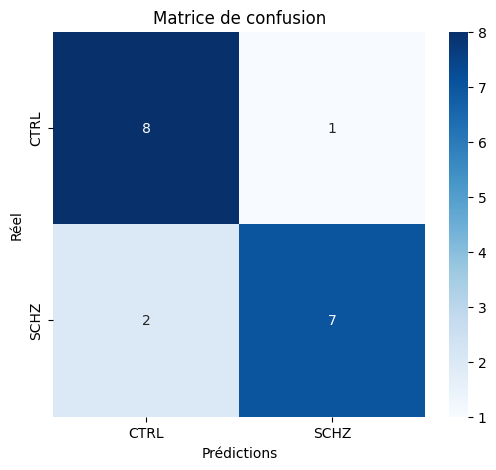

In [18]:
# ----------------------------
# 5️⃣ Évaluation du modèle
# ----------------------------

# 📌 Charger le meilleur modèle sauvegardé avec `weights_only=True`
best_model_path = "Model/best_resnet18_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))  
model.to(device)
model.eval()

# 📌 Évaluation du modèle
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📌 Calcul des performances
acc = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# 📌 Affichage des résultats
print(f"Accuracy: {acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=['CTRL', 'SCHZ']))

# 📌 Affichage de la matrice de confusion
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['CTRL', 'SCHZ'], yticklabels=['CTRL', 'SCHZ'])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()
